In [2]:
import pandasql as ps
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
# Offline mode
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)

In [4]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = pd.DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in data.columns]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# frame as supervised learning
n_hours = 24
n_features = 10
full = series_to_supervised(full, n_hours, 24)
print(full.shape)
# load data
values = full.values
# check data is float
values = values.astype('float32')
# normalizing
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
full = pd.DataFrame(scaled, columns=full.columns)


(26257, 480)


In [6]:
full.head()

,electricity(t-24),air_temperature(t-24),dew_temperature(t-24),sea_level_pressure(t-24),wind_direction(t-24),wind_speed(t-24),month(t-24),day(t-24),weekday(t-24),hour(t-24),...,electricity(t+23),air_temperature(t+23),dew_temperature(t+23),sea_level_pressure(t+23),wind_direction(t+23),wind_speed(t+23),month(t+23),day(t+23),weekday(t+23),hour(t+23)
0,0.117219,0.223350,0.396040,0.665307,0.714286,0.512683,0.0,0.0,0.666667,0.000000,...,0.248344,0.380711,0.620462,0.385035,0.857143,0.601177,0.0,0.033333,0.333333,1.000000
1,0.245695,0.220812,0.396040,0.674829,0.714286,0.498410,0.0,0.0,0.833333,0.043478,...,0.242384,0.373096,0.620462,0.395918,0.714286,0.615450,0.0,0.066667,0.500000,0.000000
2,0.250331,0.192893,0.379538,0.678912,0.000000,0.424189,0.0,0.0,1.000000,0.086957,...,0.228477,0.362944,0.597360,0.400001,0.857143,0.689671,0.0,0.066667,0.666667,0.043478
3,0.232450,0.177665,0.356436,0.684354,0.571429,0.467009,0.0,0.0,0.000000,0.130435,...,0.217881,0.342640,0.554455,0.408164,0.857143,0.643997,0.0,0.066667,0.833333,0.086957
4,0.182119,0.185279,0.376238,0.689796,0.285714,0.467009,0.0,0.0,0.166667,0.173913,...,0.193377,0.322335,0.504951,0.414967,0.714286,0.658270,0.0,0.066667,1.000000,0.130435


In [7]:
#elec_v = electricity.values
#elec_v = elec_v.astype('float32')
#scaled = scaler.fit_transform(elec_v)
#elec_scaled = pd.DataFrame(scaled, columns=electricity.columns)
#n_hours = 3
#elec_full = series_to_supervised(elec_scaled, n_hours, 1)
#elec_full.head()

In [8]:
#full['electricity(t)'] = elec_full['electricity(t)']
#full.head()

# 4. Definition and Fitting of the Model
Time Series Forecasting (LSTM)

We divide the data between train and test data. In total we have 3 years. We'll take for the training the first two years and the thir one leave it to the testing of the training. Thet is the same as taking the first 2/3 of the data to train and the remaining 1/3 to test.

### 4.1 Test and Training Sets

In [9]:
values = full.values
train_hours = int(2*full.shape[0]/3)
train = values[:train_hours, :]
test = values[train_hours:, :]

#Separate them into Variables and Targets
n_obs = (n_hours) * n_features
train_X, train_y = train[:, :n_obs], train[:, -24*n_features:]
test_X, test_y = test[:, :n_obs], test[:, -24*n_features:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], (n_hours), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_hours), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17504, 24, 10) (17504, 240) (8753, 24, 10) (8753, 240)


### 4.2 Defining the Models

#### 4.2.1 Model 1

In [10]:
# define model
model_1 = Sequential()
model_1.add(Bidirectional(LSTM(200, activation='relu', return_sequences = True), input_shape=(train_X.shape[1], train_X.shape[2])))
model_1.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model_1.add(Dense(120))
model_1.add(Dense(240))
model_1.compile(optimizer='adam', loss='mse')

In [11]:
# fit model
history = model_1.fit(train_X, train_y, epochs=100, batch_size=24, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/100
730/730 [==============================] - 51s 68ms/step - loss: 0.0595 - val_loss: 0.0992
Epoch 2/100
730/730 [==============================] - 49s 67ms/step - loss: 0.1049 - val_loss: 0.0631
Epoch 3/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0392 - val_loss: 0.0643
Epoch 4/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0388 - val_loss: 0.0666
Epoch 5/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0359 - val_loss: 0.0584
Epoch 6/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0309 - val_loss: 0.0540
Epoch 7/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0291 - val_loss: 0.0571
Epoch 8/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0284 - val_loss: 0.0592
Epoch 9/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0281 - val_loss: 0.0602
Epoch 10/100
730/730 [==============================] - 49s 67ms/step - l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



730/730 [==============================] - 49s 67ms/step - loss: 0.0114 - val_loss: 0.0205
Epoch 34/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0113 - val_loss: 0.0203
Epoch 35/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0119 - val_loss: 0.0199
Epoch 36/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0111 - val_loss: 0.0182
Epoch 37/100
244/730 [=========>....................] - ETA: 27s - loss: 0.0107

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



730/730 [==============================] - 49s 67ms/step - loss: 0.0104 - val_loss: 0.0174
Epoch 49/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0105 - val_loss: 0.0162
Epoch 50/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0104 - val_loss: 0.0166
Epoch 51/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0102 - val_loss: 0.0168
Epoch 52/100
344/730 [=============>................] - ETA: 22s - loss: 0.0100

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



730/730 [==============================] - 49s 67ms/step - loss: 0.0099 - val_loss: 0.0147
Epoch 65/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0097 - val_loss: 0.0168
Epoch 66/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0098 - val_loss: 0.0146
Epoch 67/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0098 - val_loss: 0.0146
Epoch 68/100
631/730 [========================>.....] - ETA: 5s - loss: 0.0096

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



730/730 [==============================] - 49s 67ms/step - loss: 0.0095 - val_loss: 0.0162
Epoch 70/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0093 - val_loss: 0.0155
Epoch 71/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0095 - val_loss: 0.0149
Epoch 72/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0103 - val_loss: 0.0165
Epoch 73/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0097 - val_loss: 0.0147
Epoch 74/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0098 - val_loss: 0.0152
Epoch 75/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0095 - val_loss: 0.0152
Epoch 76/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0093 - val_loss: 0.0143
Epoch 77/100
730/730 [==============================] - 49s 67ms/step - loss: 0.0092 - val_loss: 0.0151
Epoch 78/100
730/730 [==============================] - 49s 67ms/step - loss:

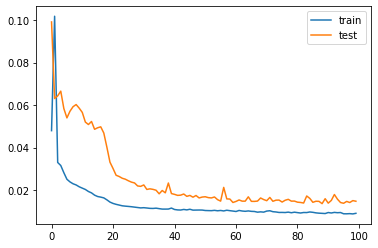

In [12]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

We create the test_input tensor to see how the network does when predicting.

In [13]:
# make a prediction
ypred = model_1.predict(test_X)
#print('ypred.shape=',ypred.shape)
test_X = test_X.reshape((test_X.shape[0], (n_hours)*n_features))
#print('test_X.shape=',test_X.shape)

# invert scaling for forecast
inv_ypred  = np.concatenate((test_X[:, :n_hours*n_features], ypred), axis=1)
full_predicted  = scaler.inverse_transform(inv_ypred )
y_predicted  = full_predicted[:,-n_hours*n_features:]
#print('inv_ypred.shape=',inv_ypred.shape)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), n_hours*n_features))
inv_y = np.concatenate((test_X[:, -n_hours*n_features:], test_y), axis=1)
full_actual = scaler.inverse_transform(inv_y)
y_actual = full_actual[:,-n_hours*n_features:]
#print('inv_y.shape=',inv_y.shape)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_predicted, y_actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.715


In [14]:
predicted = pd.DataFrame(data=full_predicted, columns=full.columns)
actual = pd.DataFrame(data=full_actual, columns=full.columns)

In [15]:
def extract_variable_df(actual_name, in_dataframe):
    out_dataframe = pd.DataFrame()
    for i in range(24):
        if i == 0:
            out_dataframe['{}_t{}'.format(actual_name, i)] = in_dataframe['{}(t)'.format(actual_name)]
        else:
            out_dataframe['{}_t{}'.format(actual_name, i)] = in_dataframe['{}(t+{})'.format(actual_name, i)]
    return out_dataframe

In [16]:
pred_electricity = extract_variable_df('electricity', predicted)
actual_electricity = extract_variable_df('electricity', actual)

In [22]:
Predicted = go.Scatter(x=np.arange(pred_electricity.shape[1]), y=pred_electricity.values[48], opacity = 1, name = 'Forecasted Value', line=dict(color='royalblue'), yaxis='y')
Actual = go.Scatter(x=np.arange(actual_electricity.shape[1]), y=actual_electricity.values[48], opacity = 0.7, name = 'Actual Value', line=dict(color='lightblue'), yaxis='y')

layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show()